In [77]:
from pandas import json_normalize
import pandas as pd
import json

In [78]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

def flattened_idx_to_layer_head(flattened_idx, num_heads):
    return flattened_idx // num_heads, flattened_idx % num_heads

def layer_head_to_flattened_idx(layer, head, num_heads):
    return layer * num_heads + head

def get_top_heads(train_idxs, val_idxs, separated_activations, separated_labels, num_layers, num_heads, seed, num_to_intervene, use_random_dir=False, specific_heads = None):

    probes, all_head_accs_np, train_accs = train_probes(seed, train_idxs, val_idxs, separated_activations, separated_labels, num_layers=num_layers, num_heads=num_heads)
    all_head_accs_np = all_head_accs_np.reshape(num_layers, num_heads)

    # if specific_heads is not None:
    #     top_heads = [layer_head_to_flattened_idx(head[0], head[1], num_heads) for head in specific_heads]
        
    if specific_heads is not None:
        #top_heads = [layer_head_to_flattened_idx(head[0], head[1], num_heads) for head in specific_heads]
        top_heads = specific_heads

    else:
        top_heads = []
        top_accs = np.argsort(all_head_accs_np.reshape(num_heads*num_layers))[::-1][:num_to_intervene]
        print(top_accs)
        #print(top_accs[0:5])
        top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in top_accs]
    if use_random_dir: 
        # overwrite top heads with random heads, no replacement
        random_idxs = np.random.choice(num_heads*num_layers, num_heads*num_layers, replace=False)
        top_heads = [flattened_idx_to_layer_head(idx, num_heads) for idx in random_idxs[:num_to_intervene]]

    return top_heads, probes

def get_interventions_dict(top_heads, probes, tuning_activations, num_heads, use_center_of_mass, use_random_dir, com_directions): 

    interventions = {}
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = []
    for layer, head in top_heads:
        if use_center_of_mass: 
            direction = com_directions[layer_head_to_flattened_idx(layer, head, num_heads)]
        elif use_random_dir: 
            direction = np.random.normal(size=(128,))
        else: 
            direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
        direction = direction / np.linalg.norm(direction)
        activations = tuning_activations[:,layer,head,:] # batch x 128
        proj_vals = activations @ direction.T
        proj_val_std = np.std(proj_vals)
        interventions[f"model.layers.{layer}.self_attn.head_out"].append((head, direction.squeeze(), proj_val_std))
        
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = sorted(interventions[f"model.layers.{layer}.self_attn.head_out"], key = lambda x: x[0])

    return interventions

def get_pertubations_dict(top_heads, tuning_activations, num_heads):

    interventions = {}
    for layer, head in top_heads:
        interventions[f"model.layers.{layer}.self_attn.head_out"] = []
    
    for layer, head in top_heads:

        head_actis = tuning_activations[:,layer,head,:] # batch x 128
        actis_std = np.std(head_actis, axis = 0)
        interventions[f"model.layers.{layer}.self_attn.head_out"].append((head, actis_std))
    
    for layer, head in top_heads:
        interventions[f"model.layers.{layer}.self_attn.head_out"] = sorted(interventions[f"model.layers.{layer}.self_attn.head_out"], key = lambda x: x[0])
    
    return interventions


In [79]:
df = pd.read_json("requirements_data/dataframe_open_chat_cot_moon_06022024_attentions_gt.json")

df.reset_index(drop=True, inplace=True)
correct = [0 if value == "yes" else 1 for value in df.predict.values]
df.correct = correct

In [80]:
import numpy as np 

index_dic = {}
separated_activations = []
separated_labels = []
reqs_order = []
for req_id in df['req_id'].unique():

    req_df = df[df['req_id'] == req_id].index

    #req_ids.append(req_df)
    index_dic[req_id] = list(req_df)
    
    temp_activations = df[df['req_id'] == req_id].attentions
    activations = np.array([list(sample.values()) for sample in temp_activations.values])#.shape
    batch_length = len(temp_activations)
    dim = 128
    activations = np.reshape(activations, (batch_length, 32, 32, dim))

    temp_labels = [1 if label==True else 0 for label in df[df['req_id'] == req_id]['correct'].values]
    separated_labels.append(temp_labels)
    separated_activations.append(activations)
    reqs_order.append(req_id)

number_of_examples = np.arange(len(reqs_order))

# get two folds using numpy
num_fold = 1
fold_idxs = np.array_split(number_of_examples, num_fold)

In [115]:
from sklearn.linear_model import LogisticRegression

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import SVC
def train_probes(seed, train_set_idxs, val_set_idxs, separated_head_wise_activations, separated_labels, num_layers, num_heads):
    
    all_head_accs = []
    probes = []
    train_accs = []
    all_X_train = np.concatenate([separated_head_wise_activations[i] for i in train_set_idxs], axis = 0)
    print(all_X_train.shape)
    all_X_val = np.concatenate([separated_head_wise_activations[i] for i in val_set_idxs], axis = 0)
    y_train = np.concatenate([separated_labels[i] for i in train_set_idxs], axis = 0)
    print(y_train.shape)
    y_val = np.concatenate([separated_labels[i] for i in val_set_idxs], axis = 0)

    for layer in tqdm(range(num_layers)): 
        for head in range(num_heads): 
            
            X_train = all_X_train[:,layer,head,:]
            
            dim_reduction = PCA(n_components = 2).fit(X_train)
            X_train_transform = dim_reduction.transform(X_train)
            X_val = all_X_val[:,layer,head,:]
            X_val_transform = dim_reduction.transform(X_val)
            #X_train = X_train_transform
            #X_val = X_val_transform
            #clf = LogisticRegression(random_state=seed, max_iter=10000, penalty='l1', solver='liblinear', C=100000).fit(X_train, y_train)
            #clf = LogisticRegression(random_state=seed, max_iter=10000,solver='liblinear').fit(X_train, y_train) #, penalty='l1', , C=100000
            #clf = LogisticRegression(random_state=seed, max_iter=10000).fit(X_train, y_train)

            # clf = LogisticRegression(random_state=seed, C=10, penalty='elasticnet', l1_ratio= 0.5, max_iter=10000, solver='saga').fit(X_train, y_train) #, penalty='l1', , C=100000
            clf = LogisticRegression(random_state=seed, C=1000, penalty='elasticnet', l1_ratio= 0.5, max_iter=10000, solver='saga').fit(X_train, y_train) #, penalty='l1', , C=100000
            
            
            #clf = SVC().fit(X_train, y_train)
            # clf = LinearDiscriminantAnalysis().fit(X_train, y_train)
            #if clf.converged_:
             #   print("The model converged.")
            #else:
             #   print("The model did not converge. You might need to increase max_iter or change the solver.")

            y_pred = clf.predict(X_train)
            train_accs.append(accuracy_score(y_train, y_pred))
            y_val_pred = clf.predict(X_val)
            all_head_accs.append(accuracy_score(y_val, y_val_pred))

            probes.append(clf)

    all_head_accs_np = np.array(all_head_accs)
    train_accs_np = np.array(train_accs)
    return probes, all_head_accs_np, train_accs_np


In [116]:
from dataclasses import dataclass
import numpy as np
@dataclass
class Args:
    #model_name: str
    #dataset_name: str
    #activations_dataset: str
    val_ratio: float
    use_center_of_mass: bool
    use_random_dir: bool
    seed: int
    num_heads: int

args = Args(val_ratio=0.5, use_center_of_mass=False, use_random_dir=False, seed=42, num_heads=12)

num_layers =32
num_heads = 32

seed = 42

fold_results = []
fold_probes = []
for i in range(len(fold_idxs)):

    if num_fold == 1: 
        train_idxs = np.arange(len(reqs_order))
    else:
        train_idxs = np.concatenate([fold_idxs[j] for j in range(num_fold) if j != i])

    val_ratio = args.val_ratio
    seed = 42  # You can choose your own seed value
    rng = np.random.default_rng(seed)
    size = int(len(train_idxs)*(1-val_ratio))
    #print(size)
    train_set_idxs = rng.choice(train_idxs, size=size, replace=False)
    val_set_idxs = np.array([x for x in train_idxs if x not in train_set_idxs])

    if len(fold_idxs) == 1:
        test_idxs = val_set_idxs
    else:
        test_idxs = fold_idxs[i]

    print(fold_idxs)
    print(train_idxs)
    print("Train indexes:" , train_set_idxs)
    print("Validation indexes: ", val_set_idxs)
    #print(test_idxs)

    train_index_list = np.concatenate([list(index_dic.values())[i] for i in train_set_idxs], axis = 0)
    train_set = df.loc[train_index_list]

    rng = np.random.default_rng(seed)
    val_idxs = val_set_idxs
    probes, all_head_accs_np, train_accs = train_probes(seed, train_set_idxs, val_idxs, separated_activations, separated_labels, num_layers=num_layers, num_heads=num_heads)
    fold_probes.append(probes)
    fold_results.append(all_head_accs_np)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Train indexes: [17 34  5 31 38 25  4  1 15 18 24  2 39 22 29 32 28 10 19 16]
Validation indexes:  [ 0  3  6  7  8  9 11 12 13 14 20 21 23 26 27 30 33 35 36 37]
(116, 32, 32, 128)
(116,)


  0%|          | 0/32 [00:00<?, ?it/s]

In [22]:
top_heads, probes = get_top_heads(train_set_idxs, val_set_idxs, separated_activations
                                  ,separated_labels
                                  ,num_layers, num_heads
                                  ,args.seed, args.num_heads, args.use_random_dir
                                  ,specific_heads= [(13,0)])
        
print("Heads intervened: ", sorted(top_heads))

(116, 32, 32, 128)
(116,)


  0%|          | 0/32 [00:00<?, ?it/s]

Heads intervened:  [(13, 0)]


In [117]:
def calculate_interventions(top_heads, tuning_activations, probes):
    tuning_activations = separated_activations
    tuning_activations = np.concatenate(tuning_activations, axis = 0)

    interventions = {}
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = []
    for layer, head in top_heads:
        print("Head: ", layer, head)
        direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
        
        ## normalize direction vector to unit vector (magnitude equal to 1)
        direction = direction / np.linalg.norm(direction)
        
        activations = tuning_activations[:,layer,head,:] # batch x 128
        print("Standard deviation of activations: ", np.std(activations))
        #print("Mean of activations: ", np.mean(activations))
        #print("Top 25% quantile of activations: ", np.quantile(activations, 0.25))
        proj_vals = activations @ direction.T
        proj_val_std = np.std(proj_vals)
        #print("Mean of projected activations: ", np.mean(proj_vals))
        print("Standard deviation of projected activations: ", proj_val_std)
        interventions[f"model.layers.{layer}.self_attn.head_out"].append((head, direction.squeeze(), proj_val_std))
        
    for layer, head in top_heads: 
        interventions[f"model.layers.{layer}.self_attn.head_out"] = sorted(interventions[f"model.layers.{layer}.self_attn.head_out"], key = lambda x: x[0])


In [118]:
top_heads = [(0,10), (0,26), (0,29), (0,30), (0,31)]#, (15,6), (15,7), (11,17), (31,20), (31,14), (31,7)] #(3,4), (17, 11), (9,10) ,  (17,22) , (16,8),
calculate_interventions(top_heads, tuning_activations, probes)

Head:  0 10
Standard deviation of activations:  0.01058467568804536
Standard deviation of projected activations:  0.028985946758628332
Head:  0 26
Standard deviation of activations:  0.013938439811420315
Standard deviation of projected activations:  0.01847668371318356
Head:  0 29
Standard deviation of activations:  0.028452099179924174
Standard deviation of projected activations:  0.043212244105866625
Head:  0 30
Standard deviation of activations:  0.010196154980468356
Standard deviation of projected activations:  0.013789622970473267
Head:  0 31
Standard deviation of activations:  0.01892548673836041
Standard deviation of projected activations:  0.04895402788901912


In [63]:
#activations = tuning_activations[:,layer,head,:]#.squeeze()
#activations

In [62]:
np.squeeze(activations[:]).shape

(231, 128)

In [104]:
tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)

for layer in range(num_layers): 
    layer_wise_proj_vals_std = []
    for head in range(num_heads): 

        direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
        ## normalize direction vector to unit vector (magnitude equal to 1)
        direction = direction / np.linalg.norm(direction)
        activations = tuning_activations[:,layer,head,:] # batch x 128
        #print("Standard deviation of activations: ", np.std(activations))
        #print("Mean of activations: ", np.mean(activations))
        #print("Top 25% quantile of activations: ", np.quantile(activations, 0.25))
        proj_vals = activations @ direction.T
        proj_val_std = np.std(proj_vals)
        layer_wise_proj_vals_std.append(proj_val_std)
        #if head == 0:
        #    break
    
    print(np.array(layer_wise_proj_vals_std).mean())
    if layer == 0: 
        break

        

0.01574678062536438


In [ ]:
layer = 

tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)

direction = probes[layer_head_to_flattened_idx(layer, head, num_heads)].coef_
## normalize direction vector to unit vector (magnitude equal to 1)
direction = direction / np.linalg.norm(direction)
activations = tuning_activations[:,layer,head,:] # batch x 128
#print("Standard deviation of activations: ", np.std(activations))
#print("Mean of activations: ", np.mean(activations))
#print("Top 25% quantile of activations: ", np.quantile(activations, 0.25))
proj_vals = activations @ direction.T
proj_val_std = np.std(proj_vals)
layer_wise_proj_vals_std.append(proj_val_std)



In [105]:
layer_wise_proj_vals_std

[0.0038682095251036754,
 0.005168662077184656,
 0.005537782856637805,
 0.005836784680470983,
 0.0016907519316366618,
 0.0014966933159638407,
 0.0018901197085068502,
 0.001735472914239788,
 0.005111018046141044,
 0.005059150215719437,
 0.06028440845628022,
 0.005052324761457373,
 0.0027360222119606186,
 0.0029593232282342915,
 0.003838662223187874,
 0.002956890657432043,
 0.01766405464097904,
 0.002108378068446699,
 0.0018994328356988584,
 0.002049289908994907,
 0.00942227204635391,
 0.01514249751039714,
 0.006901150865324089,
 0.010745450444103395,
 0.01010704709908854,
 0.0025123684148079225,
 0.057339493681748774,
 0.006438956928853606,
 0.01599314270195474,
 0.1126132738598384,
 0.0445371725885617,
 0.07320072160635124]

In [108]:
activations.shape

(231, 128)

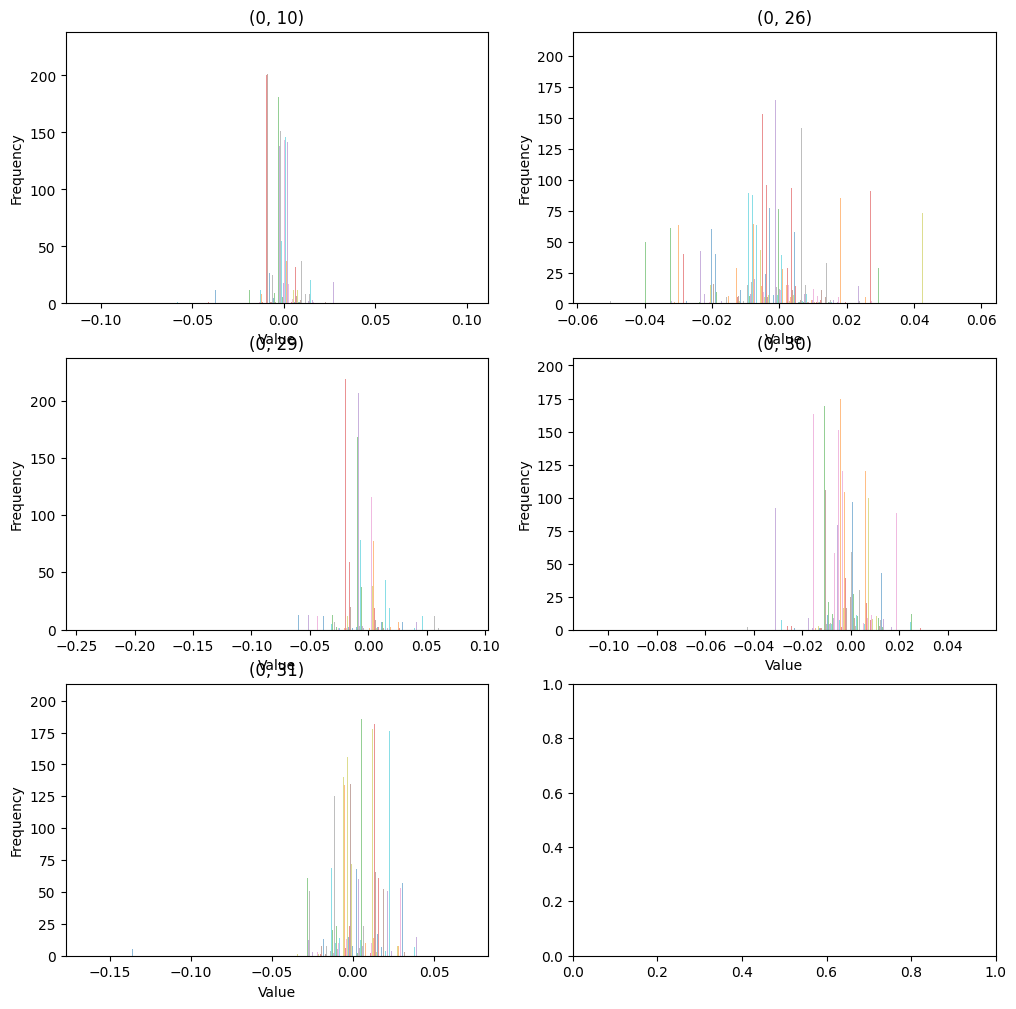

In [109]:
import matplotlib.pyplot as plt
top_heads = [(0,10), (0,26), (0,29), (0,30), (0,31)]
n_rows = len(top_heads) // 2 + 1
# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 12))

for id, head in enumerate(top_heads): 
    layer = head[0]
    h = head[1]
    activations = tuning_activations[:,layer,h,:].squeeze() # batch x 128
    
    ax = fig.axes[id]
    # Plot a histogram on the first subplot
    ax.hist(activations, bins=30, alpha=0.5)#, color='blue', edgecolor='black')
    ax.set_title(str(head))
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')


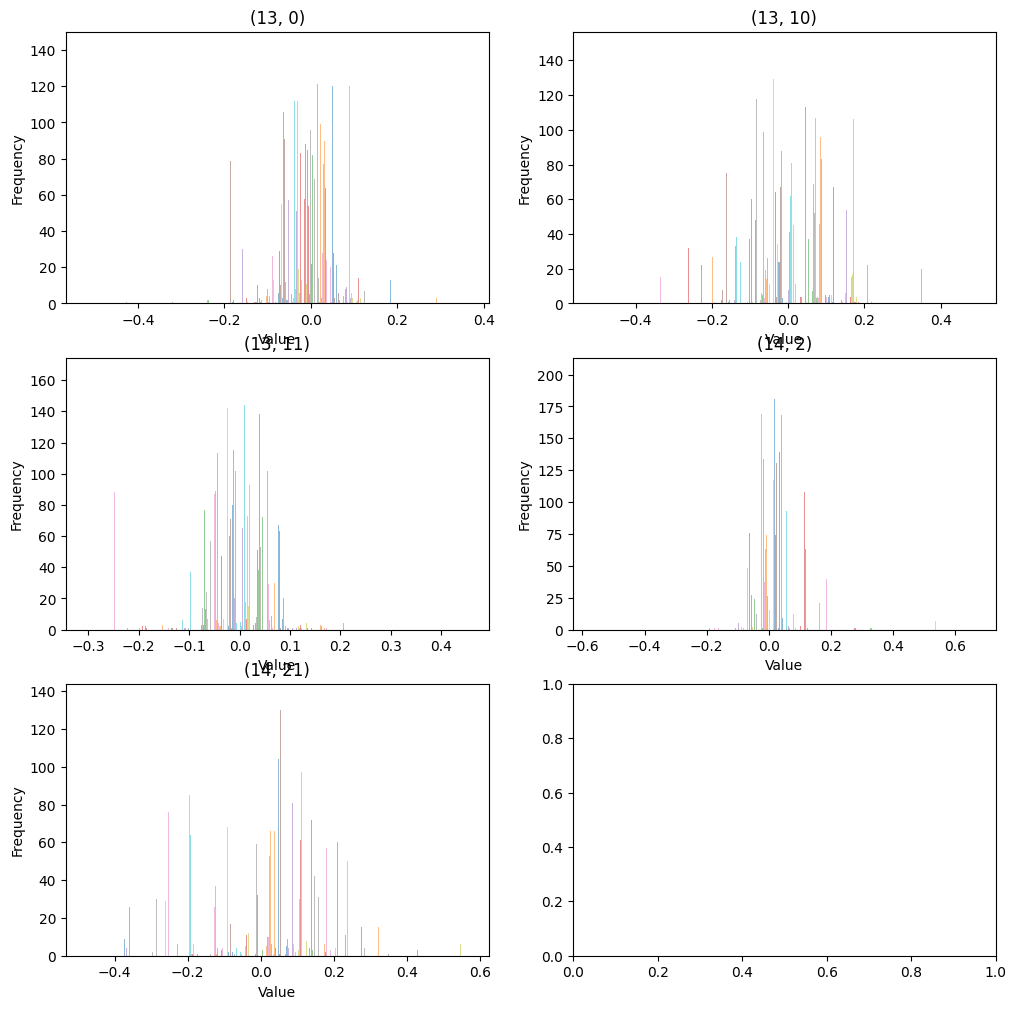

In [113]:
import matplotlib.pyplot as plt

n_rows = len(top_heads) // 2 + 1
# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 12))
top_heads = [(13,0), (13,10), (13,11), (14,2), (14,21)]#, (15,6), (15,7), (11,17), (31,20), (31,14), (31,7)] #(3,4), (17, 11), (9,10) ,  (17,22) , (16,8),

for id, head in enumerate(top_heads): 
    layer = head[0]
    h = head[1]
    activations = tuning_activations[:,layer,h,:].squeeze() # batch x 128
    ax = fig.axes[id]
    # Plot a histogram on the first subplot
    ax.hist(activations, bins=30, alpha=0.5)#, color='blue', edgecolor='black')
    ax.set_title(str(head))
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')


In [110]:
top_heads = [(0,10), (0,26), (0,29), (0,30), (0,31)]#, (15,6), (15,7), (11,17), (31,20), (31,14), (31,7)] #(3,4), (17, 11), (9,10) ,  (17,22) , (16,8),
calculate_interventions(top_heads, tuning_activations, probes)

Head:  0 10
Standard deviation of activations:  0.01058467568804536
Standard deviation of projected activations:  0.06028440845628022
Head:  0 26
Standard deviation of activations:  0.013938439811420315
Standard deviation of projected activations:  0.057339493681748774
Head:  0 29
Standard deviation of activations:  0.028452099179924174
Standard deviation of projected activations:  0.1126132738598384
Head:  0 30
Standard deviation of activations:  0.010196154980468356
Standard deviation of projected activations:  0.0445371725885617
Head:  0 31
Standard deviation of activations:  0.01892548673836041
Standard deviation of projected activations:  0.07320072160635124


In [ ]:
tuning_activations

In [114]:
top_heads = [(13,0), (13,10), (13,11), (14,2), (14,21)]#, (15,6), (15,7), (11,17), (31,20), (31,14), (31,7)] #(3,4), (17, 11), (9,10) ,  (17,22) , (16,8),
calculate_interventions(top_heads, tuning_activations, probes)

Head:  13 0
Standard deviation of activations:  0.0642626168612456
Standard deviation of projected activations:  0.13485416963311198
Head:  13 10
Standard deviation of activations:  0.10235311834307727
Standard deviation of projected activations:  0.11625994655161685
Head:  13 11
Standard deviation of activations:  0.05717773361567137
Standard deviation of projected activations:  0.12984422794260597
Head:  14 2
Standard deviation of activations:  0.07707906625122031
Standard deviation of projected activations:  0.0912156446745788
Head:  14 21
Standard deviation of activations:  0.14563568588806897
Standard deviation of projected activations:  0.13797411729311718


In [27]:
np.std(activations)

0.0642626168612456

In [28]:
proj_val_std

0.108169954048495

In [17]:
tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)
#tuning
#print(tuning_activations.shape)
#print(len(tuning_activations))
#print(tuning_activations.shape)

com_directions = None
interventions = get_interventions_dict(top_heads, probes, tuning_activations, num_heads, args.use_center_of_mass, args.use_random_dir, com_directions)

/tmp/ipykernel_291986/121174452.py:49: RuntimeWarning: invalid value encountered in divide
  direction = direction / np.linalg.norm(direction)


In [7]:
top_heads, probes = get_top_heads(train_set_idxs, val_set_idxs, separated_activations
                                  ,separated_labels
                                  ,num_layers, num_heads
                                  ,args.seed, args.num_heads, args.use_random_dir
                                  ,specific_heads= [(0,13)])
        
print("Heads intervened: ", sorted(top_heads))

tuning_activations = separated_activations
tuning_activations = np.concatenate(tuning_activations, axis = 0)
#tuning
#print(tuning_activations.shape)
#print(len(tuning_activations))
#print(tuning_activations.shape)

com_directions = None
interventions = get_interventions_dict(top_heads, probes, tuning_activations, num_heads, args.use_center_of_mass, args.use_random_dir, com_directions)


(116, 32, 32, 128)
(116,)


  0%|          | 0/32 [00:00<?, ?it/s]

Heads intervened:  [13]


TypeError: cannot unpack non-iterable int object

In [8]:
# pertubations = get_pertubations_dict(top_heads, tuning_activations, num_heads)
# pertubations

In [111]:
# interventions

#### We get the Covariance matrix --> scatter matrix per head and class
#### Calculate the lda? 
#### We need to identify the head that separates the different classes the best --> Eigenscore? 
#### We then need to find a direction that separates the classes --> Eigenvector? 
#### Could the problem also be with the data??? --> no
#### BUT even heads that there identified for the "better" dataset does not have good direction with probe methodology 


In [ ]:
import numpy as np

def lda_direction(X, y):
    # Separate the data into classes
    class_0 = X[y == 0]
    class_1 = X[y == 1]
    
    # Compute the mean of each class
    mean_0 = np.mean(class_0, axis=0)
    mean_1 = np.mean(class_1, axis=0)
    
    # Compute the overall mean
    overall_mean = np.mean(X, axis=0)
    
    # Compute the within-class scatter matrix
    S_w = np.cov(class_0, rowvar=False) * (len(class_0) - 1) + np.cov(class_1, rowvar=False) * (len(class_1) - 1)
    
    # Compute the between-class scatter matrix
    mean_diff = (mean_0 - mean_1).reshape(-1, 1)
    S_b = np.dot(mean_diff, mean_diff.T)
    
    # Solve the generalized eigenvalue problem for the matrix inv(S_w).dot(S_b)
    eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
    
    # Find the eigenvector with the largest eigenvalue
    max_eigvec = eigvecs[:, np.argmax(eigvals)]
    
    return max_eigvec

# Example usage:
# Assuming X is your data matrix (n_samples, n_features) and y is your label vector (n_samples,)
# X = np.array([...])
# y = np.array([...])
# direction = lda_direction(X, y)
# print("Direction that best separates the classes:", direction)


In [ ]:
def _solve_eigen(self, X, y, shrinkage, covariance_estimator):
        """Eigenvalue solver.

        The eigenvalue solver computes the optimal solution of the Rayleigh
        coefficient (basically the ratio of between class scatter to within
        class scatter). This solver supports both classification and
        dimensionality reduction (with any covariance estimator).

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data.

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values.

        shrinkage : 'auto', float or None
            Shrinkage parameter, possible values:
              - None: no shrinkage.
              - 'auto': automatic shrinkage using the Ledoit-Wolf lemma.
              - float between 0 and 1: fixed shrinkage constant.

            Shrinkage parameter is ignored if  `covariance_estimator` i
            not None

        covariance_estimator : estimator, default=None
            If not None, `covariance_estimator` is used to estimate
            the covariance matrices instead of relying the empirical
            covariance estimator (with potential shrinkage).
            The object should have a fit method and a ``covariance_`` attribute
            like the estimators in sklearn.covariance.
            if None the shrinkage parameter drives the estimate.

            .. versionadded:: 0.24

        Notes
        -----
        This solver is based on [1]_, section 3.8.3, pp. 121-124.

        References
        ----------
        .. [1] R. O. Duda, P. E. Hart, D. G. Stork. Pattern Classification
           (Second Edition). John Wiley & Sons, Inc., New York, 2001. ISBN
           0-471-05669-3.
        """
        self.means_ = _class_means(X, y)
        self.covariance_ = _class_cov(
            X, y, self.priors_, shrinkage, covariance_estimator
        )

        Sw = self.covariance_  # within scatter
        St = _cov(X, shrinkage, covariance_estimator)  # total scatter
        Sb = St - Sw  # between scatter

        evals, evecs = linalg.eigh(Sb, Sw)
        self.explained_variance_ratio_ = np.sort(evals / np.sum(evals))[::-1][
            : self._max_components
        ]
        evecs = evecs[:, np.argsort(evals)[::-1]]  # sort eigenvectors

        self.scalings_ = evecs
        self.coef_ = np.dot(self.means_, evecs).dot(evecs.T)
        self.intercept_ = -0.5 * np.diag(np.dot(self.means_, self.coef_.T)) + np.log(
            self.priors_
        )